In [ ]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
import os

app_dir = os.path.join(os.getcwd(), "app")
load_dotenv(os.path.join(app_dir, ".env"))

loader = DirectoryLoader("./data", glob="**/*.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
chunks = text_splitter.split_documents(docs)

In [ ]:
# RAGAS expects a file_name dict as key
for document in chunks:
    document.metadata["file_name"] = document.metadata["source"]

In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

embeddings = OpenAIEmbeddings()
model = ChatOpenAI()

generator = TestsetGenerator.from_langchain(
    embeddings=embeddings, generator_llm=model, critic_llm=model
)

testset = generator.generate_with_langchain_docs(
    chunks,
    test_size=8,
    distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25},
)

In [ ]:
testset.to_pandas()

In [ ]:
from langchain_openai.embeddings import OpenAIEmbeddings

from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()
model = ChatOpenAI()

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

import pandas as pd

df = pd.read_csv("./questions_answers/qa.csv", delimiter=";")
questions = df["question"].tolist()
ground_truth = df["ground_truth"].tolist()

In [ ]:
ground_truth

In [15]:
from datasets import Dataset

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append(
        [doc.page_content for doc in retriever.get_relevant_documents(query)]
    )

dataset = Dataset.from_dict(data)

In [23]:
first_entry = {
    "question": data["question"][0],
    "answer": data["answer"][0],
    "contexts": data["contexts"][0],
    "ground_truth": data["ground_truth"][0],
}
first_entry

{'question': 'Where was Amico born?',
 'answer': 'There is no specific information provided in the context about where Amico was born.',
 'contexts': ['The Journey to Chef Amico',
  'growing fame. She was greeted by Amico himself, whose eyes sparkled with the joy of a man who loved his work.',
  'corner of the city, the restaurant quickly gained fame for its authentic flavors and Amico’s innovative twists on traditional recipes.',
  'Creating Chef Amico’s Restaurant'],
 'ground_truth': 'Amico was born in the heart of the old quarter of Palermo.'}

In [16]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset=dataset,
    metrics=[
        context_relevancy,
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating: 100%|██████████| 150/150 [02:13<00:00,  1.13it/s]


In [17]:
result.to_pandas()

,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,Where was Amico born?,There is no specific information provided in t...,"[The Journey to Chef Amico, growing fame. She ...",Amico was born in the heart of the old quarter...,0.200000,1.000000,0.0,NaN,0.000000
1,What was Amico's early culinary influence?,Amico's early culinary influence was the flavo...,"[The Journey to Chef Amico, Amico, a chef whos...",Amico was influenced by the cooking in his Non...,0.250000,0.250000,0.0,NaN,0.996488
2,What skill did Amico learn from Palermo's mark...,Amico learned to choose the freshest fish from...,"[In the heart of the old quarter of Palermo, a...",Amico learned to select the freshest fish and ...,0.200000,0.416667,1.0,1.0,0.916103
3,Where in Italy did Amico gain culinary experie...,Amico gained culinary experience in Italy.,"[The Journey to Chef Amico, Amico, a chef whos...",Amico gained culinary experience across variou...,0.250000,0.750000,0.0,NaN,0.974462
4,"What is ""Chef Amico"" restaurant known for?",Chef Amico's restaurant is known for its authe...,"[Creating Chef Amico’s Restaurant, The Journey...",Chef Amico is known for combining Sicilian and...,0.200000,0.750000,1.0,1.0,0.992862
5,What does Amico's restaurant menu reflect?,Amico's restaurant menu reflects a tapestry of...,"[At Chef Amico, every dish told a story. The m...",The menu reflects Amico's culinary journey and...,0.142857,1.000000,1.0,1.0,1.000000
6,How does Amico perceive hospitality?,"Amico perceives hospitality as an art form, be...","[Philosophy of Hospitality, For Amico, hospita...",Amico sees hospitality as an art of celebratin...,0.142857,1.000000,1.0,1.0,1.000000
7,"What distinguishes ""Chef Amico"" in Palermo?",Chef Amico in Palermo is distinguished by its ...,[the richness of life. Chef Amico is more than...,Chef Amico is distinguished by Amico's dedicat...,0.142857,0.000000,1.0,0.5,0.993123
8,What activities does Amico engage in besides c...,"Amico engages in activities such as learning, ...","[The Journey to Chef Amico, Creating Chef Amic...","Amico mentors young chefs, conducts culinary w...",0.200000,0.500000,0.0,1.0,0.965179
9,How is Amico's legacy beyond his dishes?,Amico's legacy is beyond his dishes in the way...,[the richness of life. Chef Amico is more than...,Amico's legacy lies in his community involveme...,0.166667,0.250000,1.0,1.0,0.945420


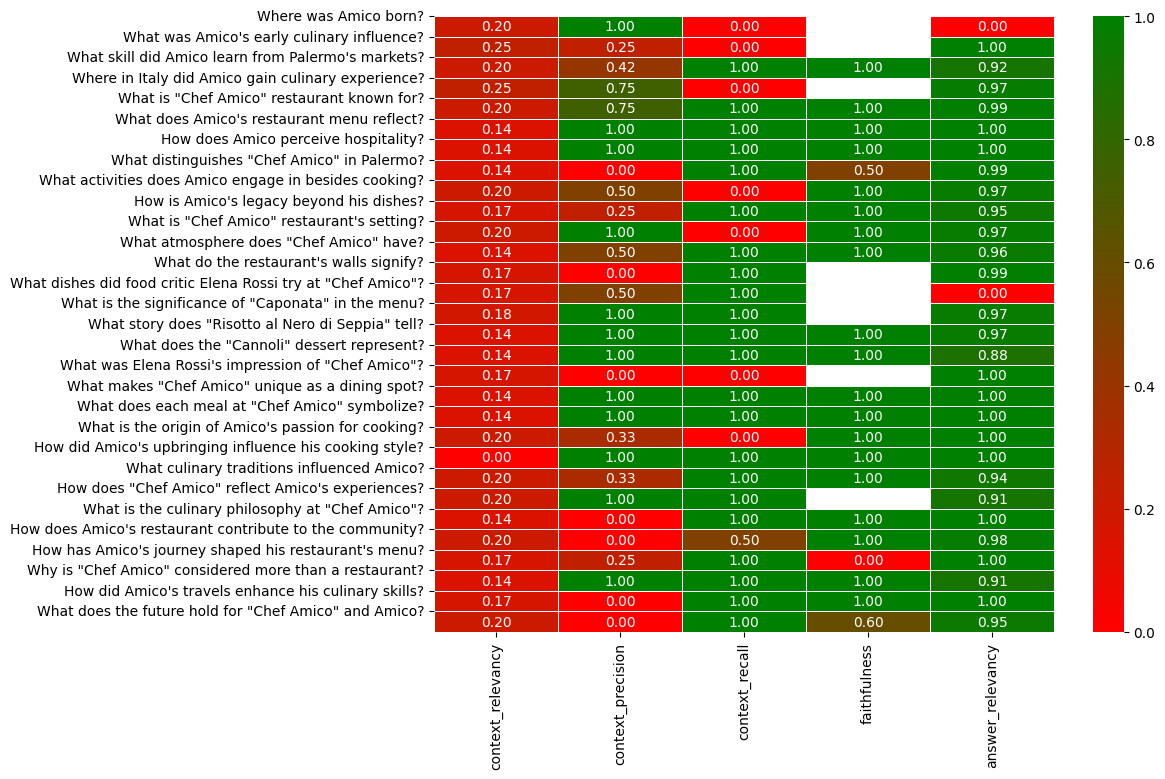

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[
    [
        "context_relevancy",
        "context_precision",
        "context_recall",
        "faithfulness",
        "answer_relevancy",
    ]
]

cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap)

plt.yticks(ticks=range(len(df["question"])), labels=df["question"], rotation=0)

plt.show()